# CNN - Melanoma Detection

## Problem statement
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Data Reading/Data Understanding

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
#Train dataset has 2239 images
#Test dataset has 118 images

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

In [7]:
print("Train data classification")
for f in list(data_dir_train.glob('*')):
    folder = os.path.basename(f)
    print(folder,":",len(list(f.glob('*.jpg'))))

print("\nTest data classification")
for f in list(data_dir_test.glob('*')):
    folder = os.path.basename(f)
    print(folder,":",len(list(f.glob('*.jpg'))))

Train data classification
melanoma : 438
seborrheic keratosis : 77
dermatofibroma : 95
squamous cell carcinoma : 181
vascular lesion : 139
actinic keratosis : 114
nevus : 357
basal cell carcinoma : 376
pigmented benign keratosis : 462

Test data classification
melanoma : 16
seborrheic keratosis : 3
dermatofibroma : 16
squamous cell carcinoma : 16
vascular lesion : 3
actinic keratosis : 16
nevus : 16
basal cell carcinoma : 16
pigmented benign keratosis : 16


In [8]:
#Multi Class classification problem
#Class imbalance exist in dataset

### Dataset Creation

- Train (80%) & validation (20%) dataset creation from the train directory with a batch size of 32. 
- Resize images to 180*180.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
#Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
#Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
#Class Names in train dataset
class_names = train_ds.class_names
print(class_names)
num_class = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Dataset visualisation

 Visualize one instance of all the nine classes present in the dataset 

In [13]:
import matplotlib.pyplot as plt

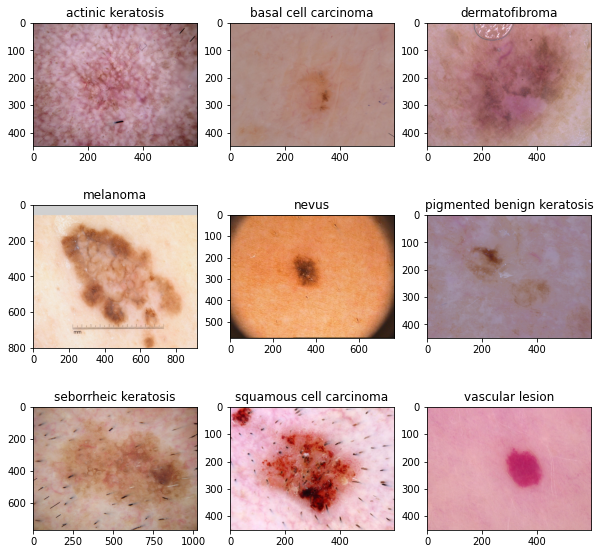

In [14]:
plt.figure(figsize=(10,10))
i=0
for c in class_names: 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(c+'/*.jpg'))[1]))
  plt.title(c)
  plt.imshow(image)
  i = i+1

In [15]:
#One Hot encoding
def convert_to_categorical(image, mask):
    mask = tf.one_hot(tf.cast(mask, tf.int32), 9)
    mask = tf.cast(mask, tf.float32)
    return image, mask

In [16]:
train_ds = train_ds.map(convert_to_categorical)
val_ds = val_ds.map(convert_to_categorical)

In [17]:
#Loading the data into memory
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 - Model Building & training 

In [18]:
#Build the model
#Normalize pixel values between (0,1)
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_class = len(class_names)
model1 = Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3))])
model1.add(Conv2D(32,(3,3),padding='same',activation= 'relu'))
#model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(32,(3,3),padding='same',activation= 'relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(64,(3,3),padding='same',activation= 'relu'))
#model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(64,(3,3),padding='same',activation= 'relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
#model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(Dense(num_class,activation= 'softmax'))

In [19]:
#Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        36928     
                                                        

In [21]:
#Train the model
epochs = 20
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 127ms/step - loss: 1.9653 - accuracy: 0.2746 - val_loss: 1.8105 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 1.7104 - accuracy: 0.3929 - val_loss: 1.6618 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 1.5795 - accuracy: 0.4392 - val_loss: 1.5230 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4323 - accuracy: 0.4989 - val_loss: 1.4772 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.3359 - accuracy: 0.5407 - val_loss: 1.4157 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.2432 - accuracy: 0.5647 - val_loss: 1.3897 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.1640 - accuracy: 0.5910 - val_loss: 1.4046 - val_accuracy: 0.5347
Epoch 8/20


In [22]:
#Visualizing training results
def plot_train_val_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

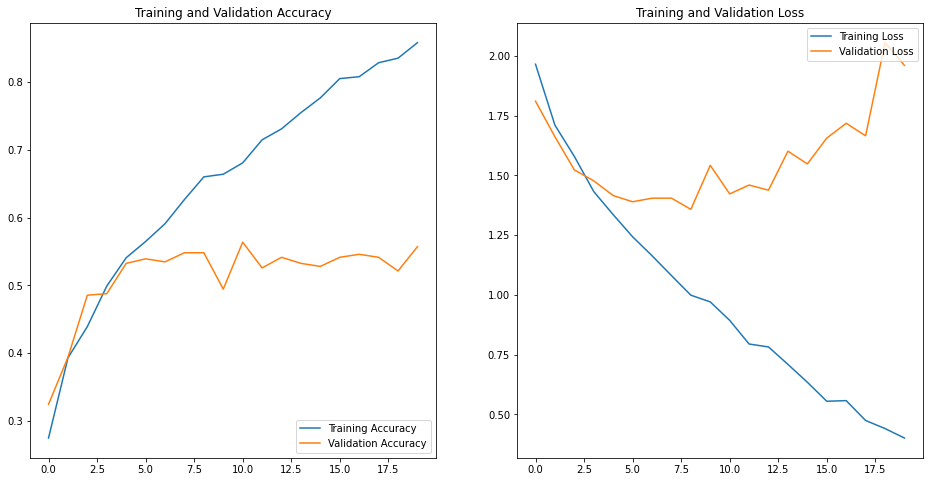

In [23]:
plot_train_val_accuracy(history1)

### Model1 : Observation

- While the training accuracy increased post 5 iterations, but the validation accuracy remain within 50 to 55 range.
- While the training loss has reduced to near 0, the validation loss has increased.
- The model is indicating overfitting.

### Data Augmentation

In [24]:
#Adding augmentation methods
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical", input_shape = (img_height,img_width,3)),
  layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3))
])

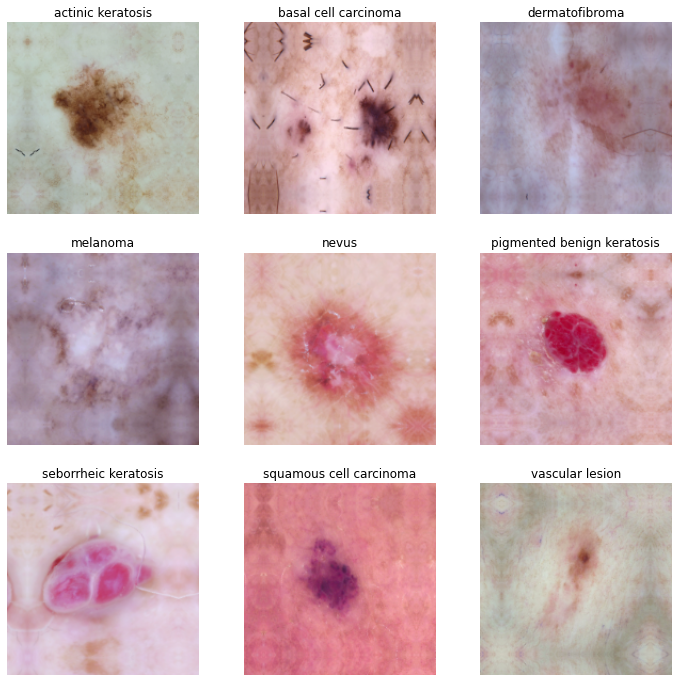

In [25]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(num_class):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

### Model 2 - Model Building & training

In [26]:
#Build the model with data augmentation
#Add drop out layer

num_class = len(class_names)
model2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(32,(3,3),padding='same',activation= 'relu'),
    layers.Conv2D(32,(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,(3,3),padding='same',activation= 'relu'),
    layers.Conv2D(64,(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class,activation= 'softmax')
])

In [27]:
#Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                      

In [29]:
#Train the model
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 86ms/step - loss: 2.0444 - accuracy: 0.2148 - val_loss: 2.0201 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 5s 83ms/step - loss: 1.8455 - accuracy: 0.3828 - val_loss: 1.8410 - val_accuracy: 0.3736
Epoch 3/20
56/56 [==============================] - 5s 83ms/step - loss: 1.7317 - accuracy: 0.4040 - val_loss: 1.7468 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 5s 83ms/step - loss: 1.6610 - accuracy: 0.4364 - val_loss: 1.7087 - val_accuracy: 0.4094
Epoch 5/20
56/56 [==============================] - 5s 84ms/step - loss: 1.6046 - accuracy: 0.4459 - val_loss: 1.6483 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 5s 84ms/step - loss: 1.5802 - accuracy: 0.4648 - val_loss: 1.6327 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 5s 84ms/step - loss: 1.5551 - accuracy: 0.4587 - val_loss: 1.6271 - val_accuracy: 0.4586
Epoch 8/20
56

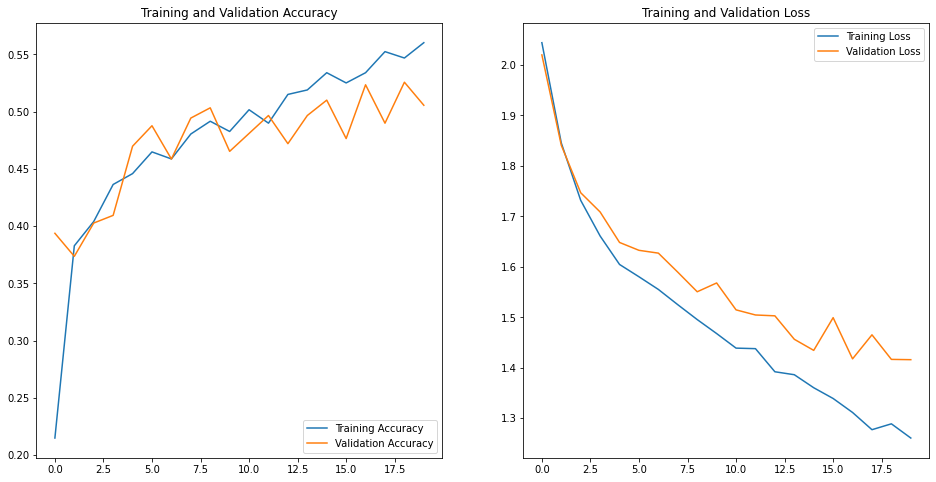

In [30]:
plot_train_val_accuracy(history2)

### Model2 : Observation
- Post data augmentation, the training accuracy is closer to validation accuracy. But the validation accuracy has not improved.
- Even though the issue of overfitting is resolved, the accuracy of the model is still not good.

### Class Distribution

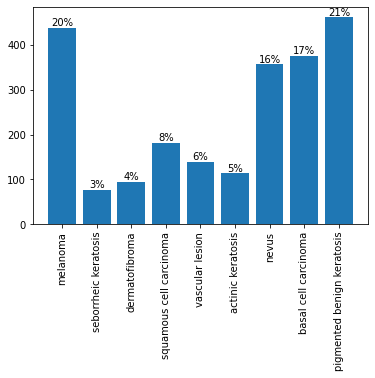

In [31]:
#Train data distribution
class_name = []
class_count = []
for f in list(data_dir_train.glob('*')):
    class_name.append(os.path.basename(f))
    class_count.append(len(list(f.glob('*.jpg'))))

p = plt.bar(class_name,class_count)

for bar in p:
    height = bar.get_height()
    plt.annotate( "{}%".format(round(height*100/sum(class_count))),(bar.get_x() + bar.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

plt.xticks(rotation=90)
plt.show()

- 'seborrheic keratosis' and 'dermatofibroma' are having the least samples, contributing to 3% and 4% respectively
- 'melanoma' and 'pigmented benign keratosis' are having the max sample size, contributing to 20% and 21% respectively
- This indicates class imbalance in the training dataset

### Handling Class Imbalance

In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F15E2073C50>: 100%|██████████| 500/500 [00:18<00:00, 27.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15E2036790>: 100%|██████████| 500/500 [00:19<00:00, 26.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1702B54250>: 100%|██████████| 500/500 [00:18<00:00, 26.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F15FA029090>: 100%|██████████| 500/500 [01:22<00:00,  6.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F15E208DED0>: 100%|██████████| 500/500 [01:17<00:00,  6.42 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F15D07EE4D0>: 100%|██████████| 500/500 [00:16<00:00, 30.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F15FA04FFD0>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F167736C550>: 100%|██████████| 500/500 [00:16<00:00, 29.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15FA0BE190>: 100%|██████████| 500/500 [00:16<00:00, 29.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000159.jpg_13ea77aa-dbdf-4553-a43c-37e56dd3efb8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010503.jpg_8e805896-c03a-4c11-986b-b00b5d4416b8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011130.jpg_b88c8114-870a-41f8-adac-82f7d309825e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010631.jpg_72131a32-645a-460a-8dbc-35514330462c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001140.jpg_80a7a3e0-179f-4698-8d7e-bf19f09bccf9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009984.jpg_78b23cc1-c9bf-4175-aae8-1036af746e31.jpg',
 'Skin cancer IS

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [39]:
#Create df from train dataset
image_dir_list = [[x,os.path.basename(os.path.dirname(x))] for x in glob(os.path.join(data_dir_train, "*", "*.jpg"))]
original_df = pd.DataFrame(image_dir_list, columns=['Path', 'Label'])
original_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma


In [40]:
new_df = original_df.append(df2)

In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [43]:
#Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [45]:
#One-Hot encoding
train_ds = train_ds.map(convert_to_categorical)
val_ds = val_ds.map(convert_to_categorical)

In [46]:
#Loading the data into memory
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
#Build the model on the balanced dataset
#Add batch normalisation
#Add drop out layer

num_class = len(class_names)
model3 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(32,(3,3),padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32,(3,3),padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,(3,3),padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128,(3,3),padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3),padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_class,activation= 'softmax')
])

In [48]:
#Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
# View the summary of all layers
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                      

In [50]:
#Train the model
epochs = 30
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 152ms/step - loss: 2.1824 - accuracy: 0.3399 - val_loss: 22.4639 - val_accuracy: 0.1039
Epoch 2/30
169/169 [==============================] - 20s 120ms/step - loss: 1.5376 - accuracy: 0.4177 - val_loss: 22.3444 - val_accuracy: 0.1314
Epoch 3/30
169/169 [==============================] - 20s 120ms/step - loss: 1.4346 - accuracy: 0.4457 - val_loss: 10.3733 - val_accuracy: 0.2532
Epoch 4/30
169/169 [==============================] - 20s 120ms/step - loss: 1.3832 - accuracy: 0.4787 - val_loss: 4.4975 - val_accuracy: 0.3682
Epoch 5/30
169/169 [==============================] - 20s 121ms/step - loss: 1.3256 - accuracy: 0.5019 - val_loss: 3.8463 - val_accuracy: 0.4172
Epoch 6/30
169/169 [==============================] - 21s 121ms/step - loss: 1.2703 - accuracy: 0.5137 - val_loss: 2.7852 - val_accuracy: 0.4625
Epoch 7/30
169/169 [==============================] - 21s 121ms/step - loss: 1.2495 - accuracy: 0.5230 - val_loss: 2.1825 - val

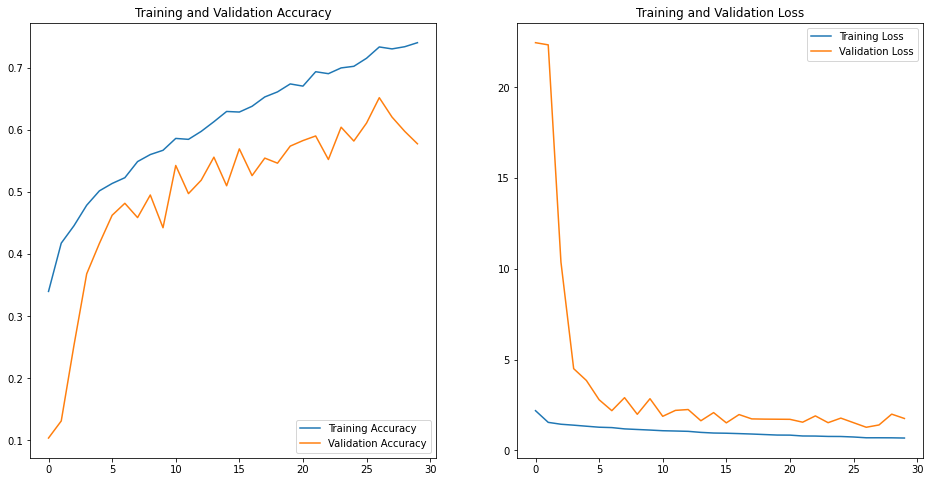

In [51]:
plot_train_val_accuracy(history3)

### Model 3 : Observation
- Post handling class imbalance, validation accuracy started increasing along with training accuracy.
- The problem of overfitting is reducing as batch normalisation and drop outs are added
- The problem further diminishes, when more layers are added into the model.